In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import random
import shutil
from PIL import Image
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_predict
import math
from sklearn.model_selection import KFold

In [48]:
N1 = 69225 % 2
N1

1

In [49]:
N1 = 699531 % 2
N1

1

### Calculando a área da Celula

In [50]:
def calculaAreaPerimetroImagem(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_colorida = np.zeros_like(img_cv2)
  cv2.drawContours(mascara_colorida, contornos, -1, (255, 255, 255), thickness=cv2.FILLED)

  # Exibir a imagem original, a máscara e a parte colorida
  area_branca = np.sum(mascara_binaria == 255)
  
  
  total_perimetro = 0
  
  for contorno in contornos:
    perimeter = cv2.arcLength(contorno, closed=True)
    total_perimetro += perimeter
  
  return area_branca, round(total_perimetro, 2)


### Calculando Compacidade

In [51]:
# perimetro^2 / 4 PI area
def calcularCompacidade(img_cv2):
  area, perimetro = calculaAreaPerimetroImagem(img_cv2)
  
  compacidade = (perimetro**2) / (area * (4 * math.pi)) 
  
  return round(compacidade, 4)

### Calculando Excentricidade

In [52]:
def calcularExcentricidades(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  maior_contorno = max(contornos, key=cv2.contourArea)

    
  if len(maior_contorno) >= 5:
    # (elipse_x, elipse_y), (eixo_maior, eixo_menor), _ = cv2.fitEllipse(maior_contorno)
    elipse = cv2.fitEllipse(maior_contorno)
    eixo_maior = max(elipse[1])
    eixo_menor = min(elipse[1])
    # Restante do seu código
  else:
    return 0


  # Calcular excentricidade
  # 1-menor^2 / 1-maior^2
  
  excentricidade = 1 - ((eixo_menor ** 2) / (eixo_maior ** 2))
  
  # if(eixo_maior != 0 and eixo_menor != 0):
  #   value_mid = round((eixo_menor / eixo_maior)**2, 2)
  # else:
  #   return 0
  
  # excentricidade = round(np.sqrt(value_mid-1),2)
  
  return excentricidade

### Gerar CSV

In [53]:
csv = {'id_cel': [],
       'label': [],
       'area': [],
       'compacidade': [],
       'excentricidade': [],
       }

path_dataset_segmentation = "./data/segmentation_dataset_binario/"
# path_dataset_segmentation = "./data/segmentation_dataset_categorical/"


for pasta_atual, subpastas, arquivos in os.walk(path_dataset_segmentation):
    for arquivo in arquivos:
        caminho_completo = os.path.join(pasta_atual, arquivo)
        
        imagem = cv2.imread(caminho_completo)
        
        
        area, _ = calculaAreaPerimetroImagem(imagem)
        
        nomeSplit = caminho_completo.split("\\")
        classeSpli = nomeSplit[0].split("/")
        nomeCel = nomeSplit[1].replace(".png", "")
        nomeClasse = classeSpli[len(classeSpli)-1]
        csv['id_cel'].append(nomeCel)

        
        csv['area'].append(round(area,2))
        csv['label'].append(nomeClasse)
        csv['compacidade'].append(calcularCompacidade(imagem))
        csv['excentricidade'].append(calcularExcentricidades(imagem))
          
  
       
df = pd.DataFrame(csv)
df.to_csv('csv_pt2_binario.csv', index=False)       
# df.to_csv('csv_pt2_categorical.csv', index=False)       


In [4]:
df = pd.read_csv("csv_pt2_binario.csv")

### Gerando scatterplot com as caracteristicas calculadas

#### Area X Compacidade

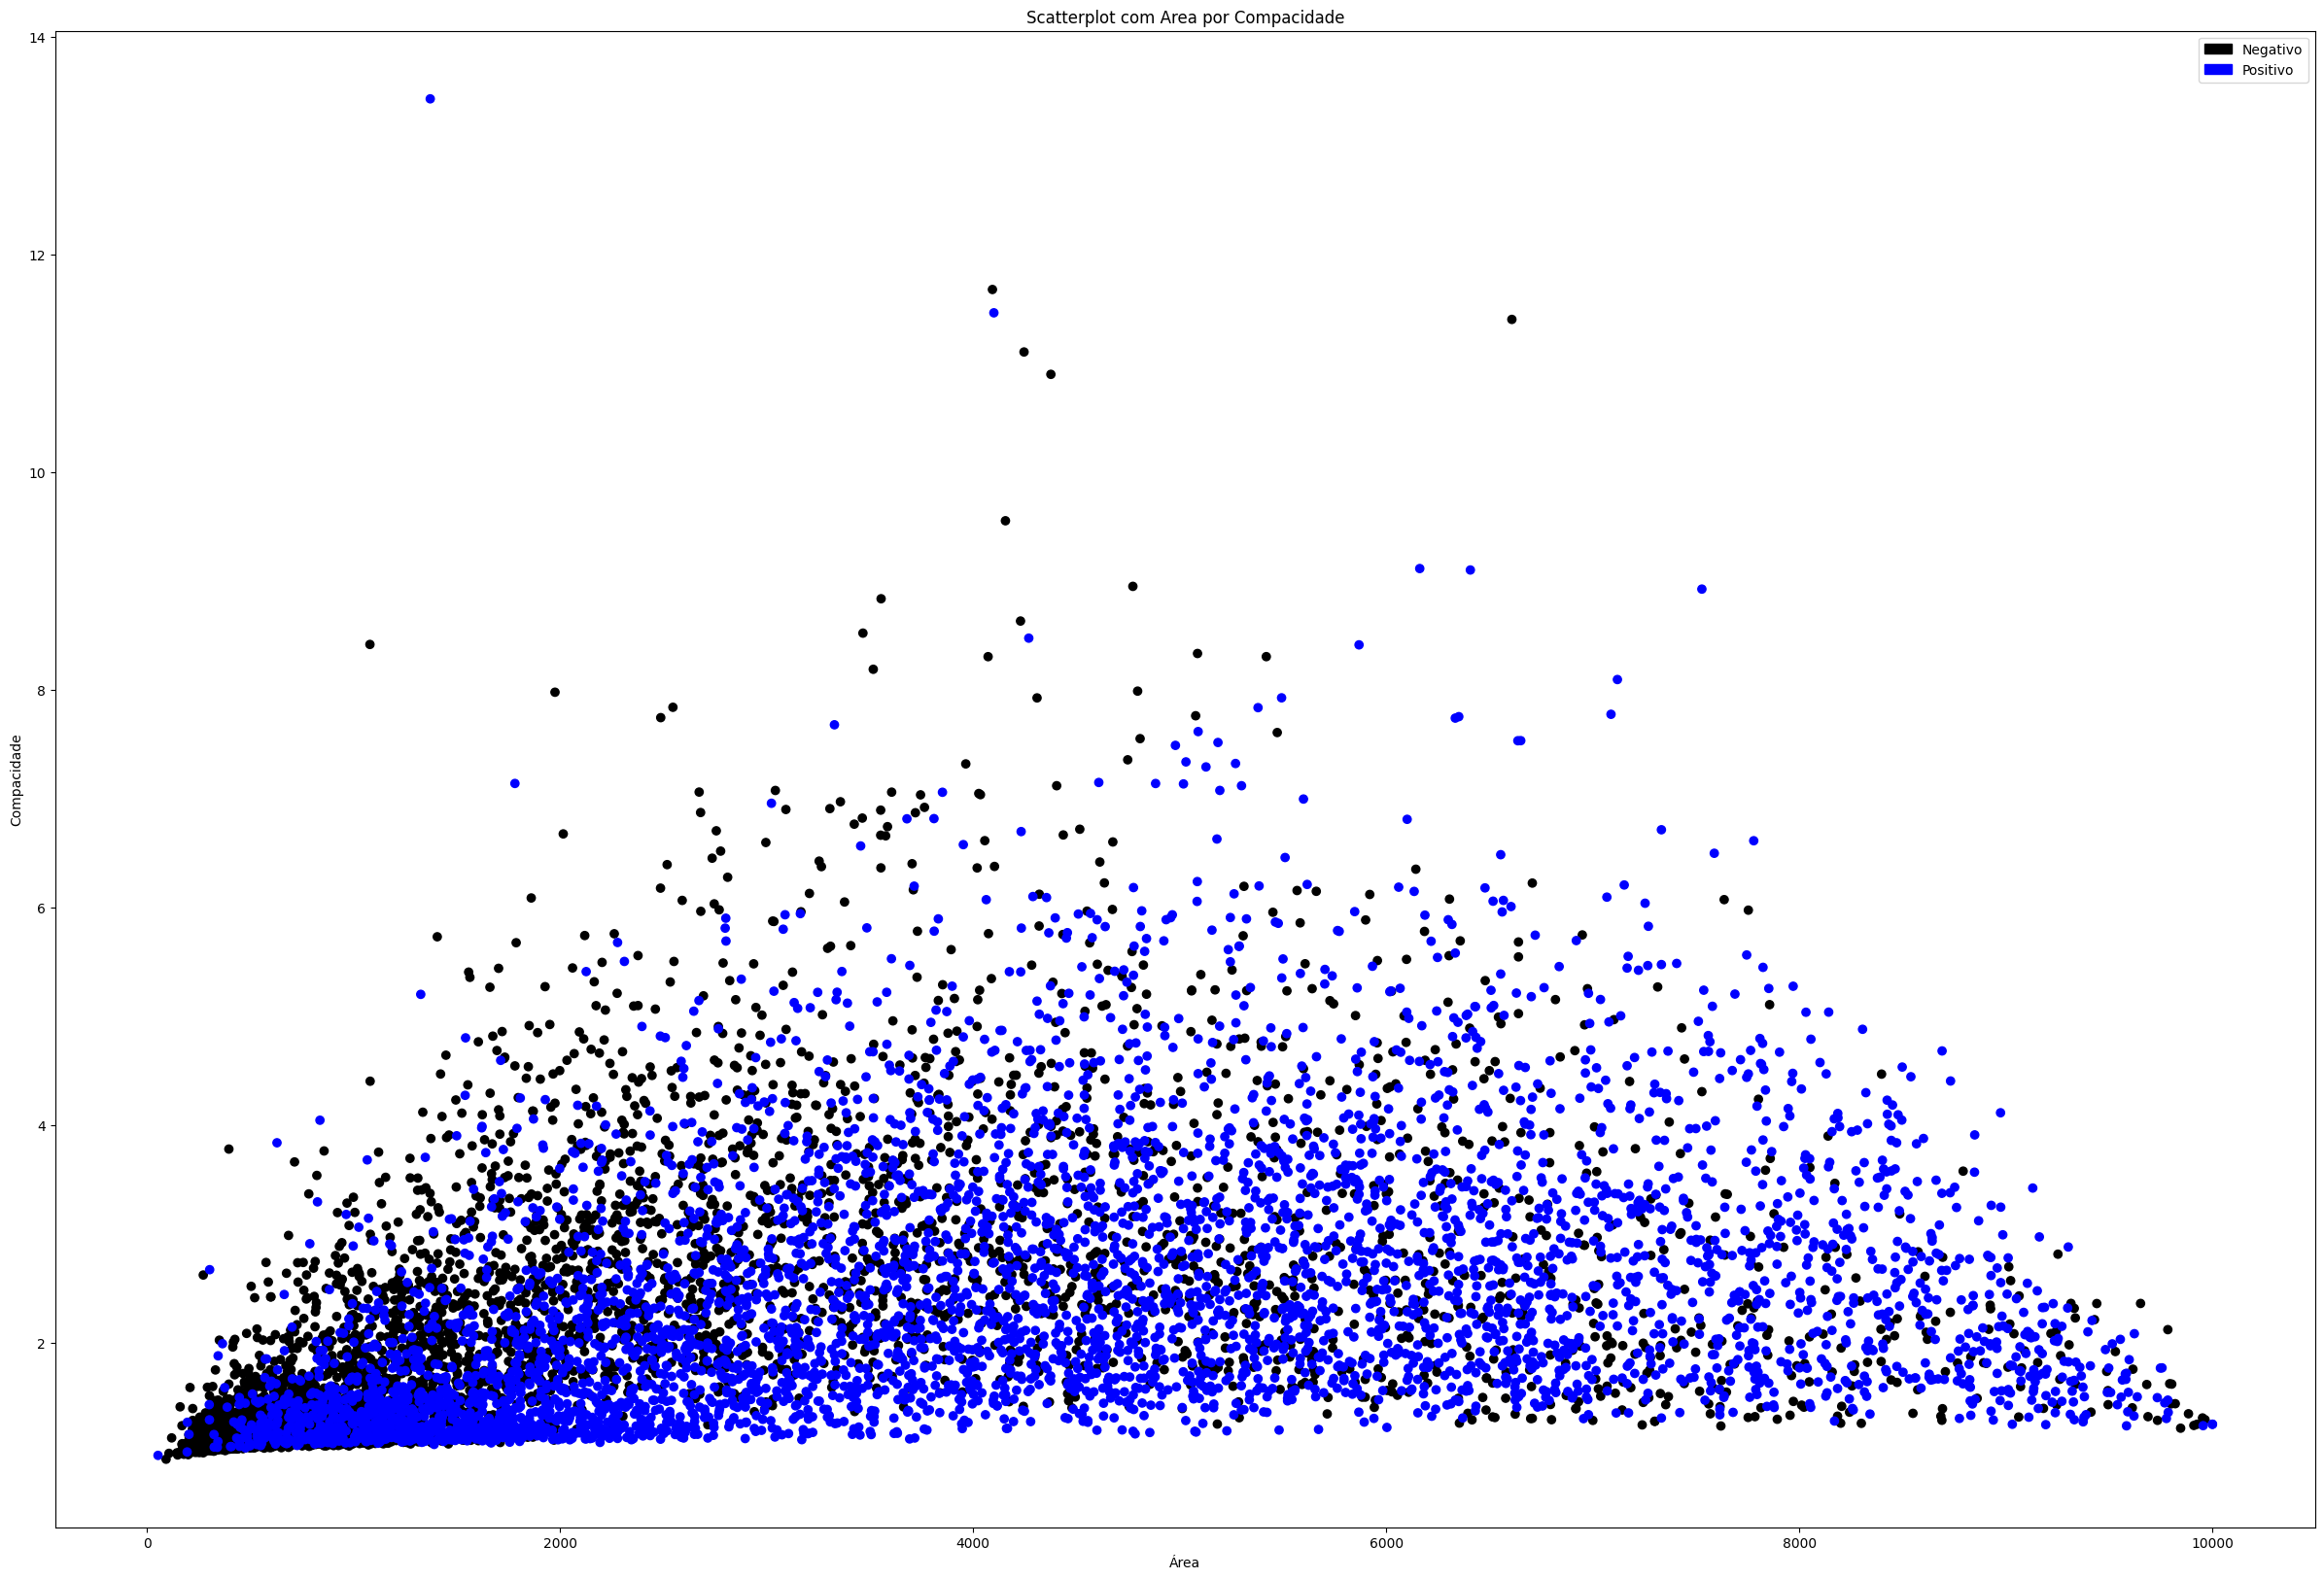

In [63]:
df = pd.read_csv('csv_pt2_binario.csv')
# df = pd.read_csv('csv_pt2_categorical.csv')

# cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}
cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df['Cor'] = df['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df['area'], df['compacidade'], c=df['Cor'], label=df['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Compacidade')
plt.title('Scatterplot com Area por Compacidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

#### Area x Excentricidade

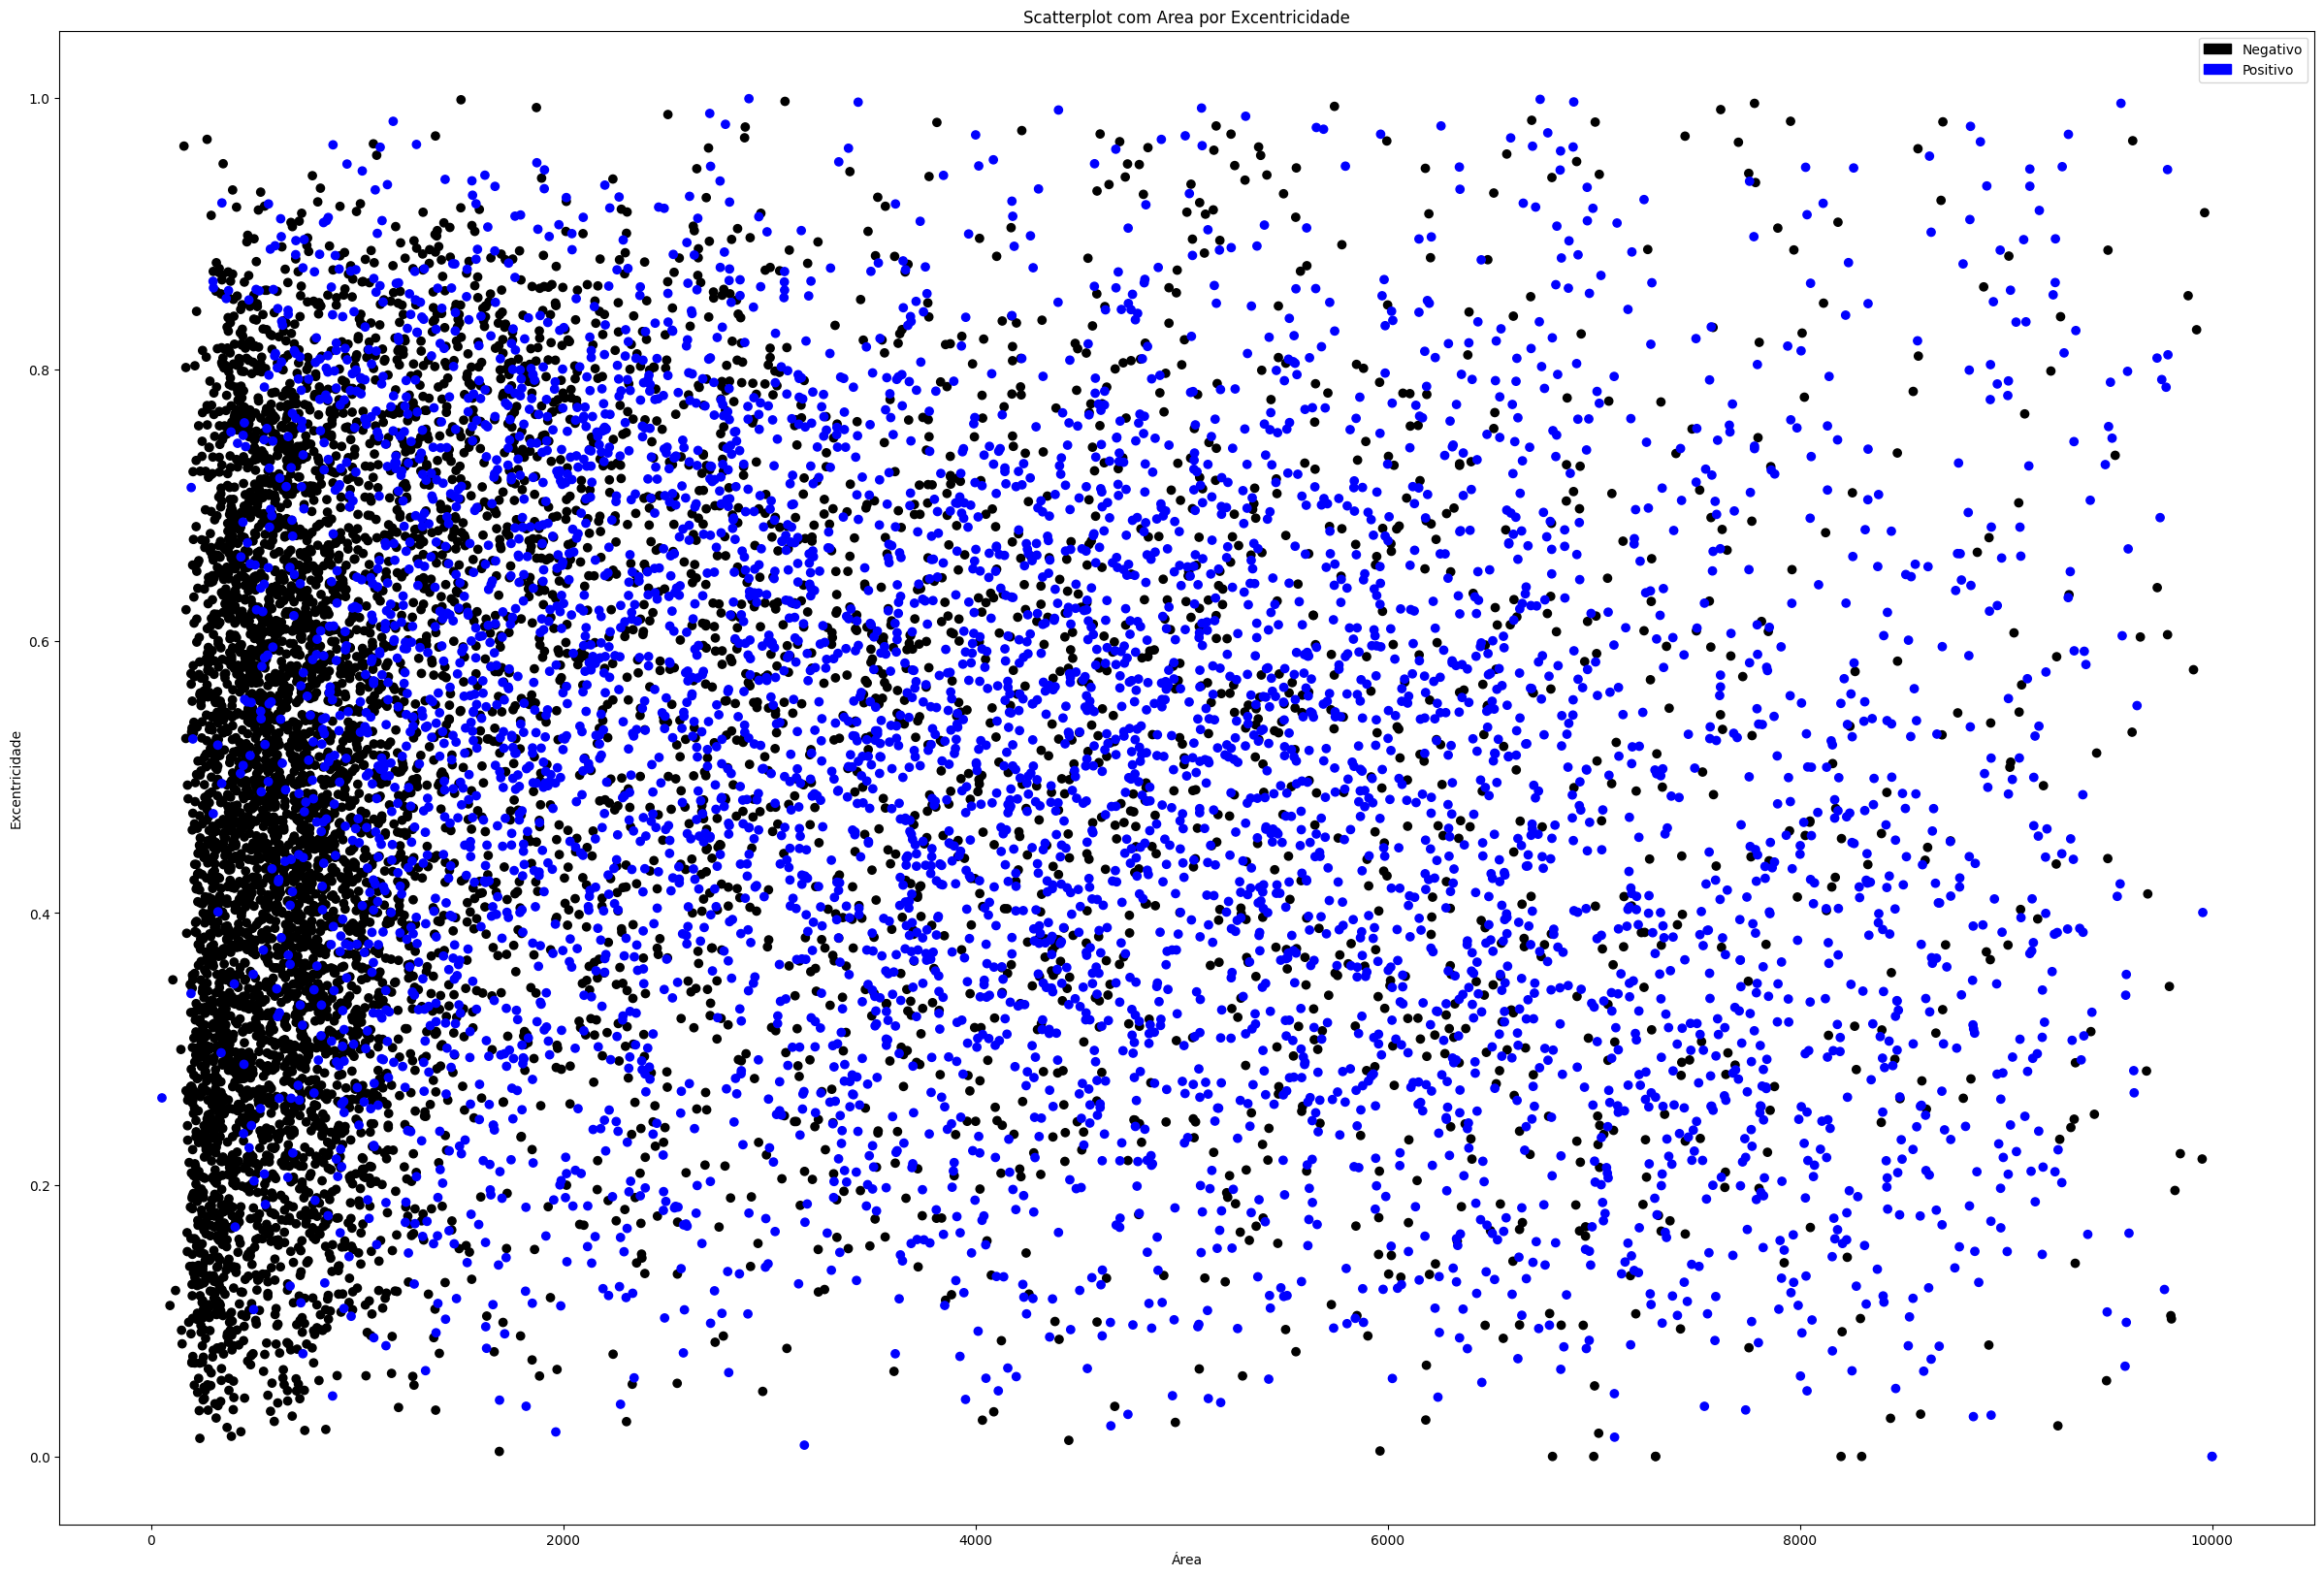

In [65]:
# df = pd.read_csv('csv_pt2.csv')
df = pd.read_csv('csv_pt2_binario.csv')

# df_filter = df[df["excentricidade"]<10 ]
df_filter = df

# cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}
cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df_filter['Cor'] = df_filter['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df_filter['area'], df_filter['excentricidade'], c=df_filter['Cor'], label=df_filter['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Excentricidade')
plt.title('Scatterplot com Area por Excentricidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# intervalos_y = [15, 25, 55, 115, 125, 155, 215, 225, 255, 315, 325, 355, 415, 425, 455, 515, 525, 555]
# plt.yticks(intervalos_y)
# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

In [145]:
df[df["excentricidade"]>20 ]

,id_cel,label,area,compacidade,excentricidade,Cor
2244,8242,HSIL,6740,3.2329,30.93,red
4412,5559,LSIL,2901,2.2425,42.50,yellow
5569,11109,Negative for intraepithelial lesion,1504,1.8052,27.02,black


### Dividindo o dataset em treino e teste

In [ ]:
def obter_nomes_pastas(diretorio):
    nomes_pastas = []
    for nome in os.listdir(diretorio):
        if os.path.isdir(os.path.join(diretorio, nome)):
            nomes_pastas.append(nome)
    return nomes_pastas
  
  
# Exemplo de uso
cwd = os.getcwd()


diretorio = cwd + "/data/segmentation_dataset/"
pastas = obter_nomes_pastas(diretorio)

diretorio_origem = diretorio
diretorio_destino = cwd + '/data/segentation_dataset_treino/'

percent = 0.8

for each in pastas:

    # Diretório contendo todas as imagens
    diretorio_imagens = diretorio_origem + f'/{each}/'

    # Diretório para salvar as imagens de treinamento
    diretorio_treinamento = diretorio_destino + f'/train/{each}/'

    # Diretório para salvar as imagens de teste
    diretorio_teste = diretorio_destino + f'/test/{each}/'

    # Lista todas as imagens no diretório
    imagens = os.listdir(diretorio_imagens)

    # Embaralha a lista de imagens
    random.shuffle(imagens)

    # Calcula o índice para dividir as imagens
    indice_divisao = int(percent * len(imagens))

    # Separa as imagens em treinamento e teste
    imagens_treinamento = imagens[:indice_divisao]
    imagens_teste = imagens[indice_divisao:]

    if not (os.path.exists(diretorio_teste)):
        os.makedirs(diretorio_teste)

    if not (os.path.exists(diretorio_treinamento)):
        os.makedirs(diretorio_treinamento)

    # Move as imagens para os diretórios correspondentes
    for imagem in imagens_treinamento:
        shutil.copy(os.path.join(diretorio_imagens, imagem),
                    diretorio_treinamento)

    for imagem in imagens_teste:
        shutil.copy(os.path.join(diretorio_imagens, imagem), diretorio_teste)



### Calculando Mahalanobis 6 Classes

In [66]:
df = pd.read_csv('./csv_pt2_binario.csv')
df

,id_cel,label,area,compacidade,excentricidade
0,1000,Negativo,3572,3.6987,0.566210
1,1001,Negativo,6284,3.9283,0.324930
2,1002,Negativo,2817,2.4419,0.533978
3,1003,Negativo,258,0.9976,0.149099
4,10034,Negativo,783,1.0642,0.177952
...,...,...,...,...,...
11529,9995,Positivo,3312,4.2011,0.587212
11530,9996,Positivo,4330,2.7364,0.569865
11531,9997,Positivo,4001,1.7752,0.972777
11532,9998,Positivo,1302,1.7914,0.734374


In [67]:
# Dividindo em treino e teste


train_df, test_df = train_test_split(df, test_size=0.8, random_state=42)


In [68]:
train_df

,id_cel,label,area,compacidade,excentricidade
1827,1965,Negativo,4257,2.3317,0.702878
9154,611,Positivo,7490,1.6803,0.506665
11162,9514,Positivo,4835,2.3222,0.817047
2376,2796,Negativo,750,1.1731,0.541601
8551,4541,Positivo,6859,2.0231,0.669913
...,...,...,...,...,...
11284,9651,Positivo,5500,3.1949,0.522412
5191,6454,Negativo,208,1.0361,0.307962
5390,6653,Negativo,232,1.0327,0.126677
860,10999,Negativo,803,1.1861,0.581455


In [69]:
def calcular_estatisticas_por_classe(df):
    estatisticas_por_classe = {}
    for classe in df['label'].unique():
        classe_df = df[df['label'] == classe]
        
        # Converta as colunas para números
        numeric_columns = ['area', 'compacidade', 'excentricidade']
        for col in numeric_columns:
            classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
        
        estatisticas_por_classe[classe] = {
            'media': np.mean(classe_df[numeric_columns], axis=0),
            'covariancia': np.cov(classe_df[numeric_columns], rowvar=False)
        }
    return estatisticas_por_classe
# Calcule as estatísticas para o conjunto de treinamento
estatisticas_treinamento = calcular_estatisticas_por_classe(train_df)


for each in estatisticas_treinamento.items():
  print(each)

('Negativo', {'media': area              1793.077327
compacidade          1.854021
excentricidade       0.488249
dtype: float64, 'covariancia': array([[3.75093652e+06, 1.22200317e+03, 6.19742620e+01],
       [1.22200317e+03, 1.50610332e+00, 3.06473985e-02],
       [6.19742620e+01, 3.06473985e-02, 4.59862515e-02]])})
('Positivo', {'media': area              4329.996920
compacidade          2.454963
excentricidade       0.515057
dtype: float64, 'covariancia': array([[ 5.67727903e+06,  8.58530031e+02, -1.00214934e+02],
       [ 8.58530031e+02,  1.47406573e+00, -5.14904650e-02],
       [-1.00214934e+02, -5.14904650e-02,  4.50473598e-02]])})


C:\Users\Viny\AppData\Local\Temp\ipykernel_48860\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\Viny\AppData\Local\Temp\ipykernel_48860\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')


Acurácia: 0.7219332466406588
Matriz de Confusão:
[[4073 1374]
 [1192 2589]]


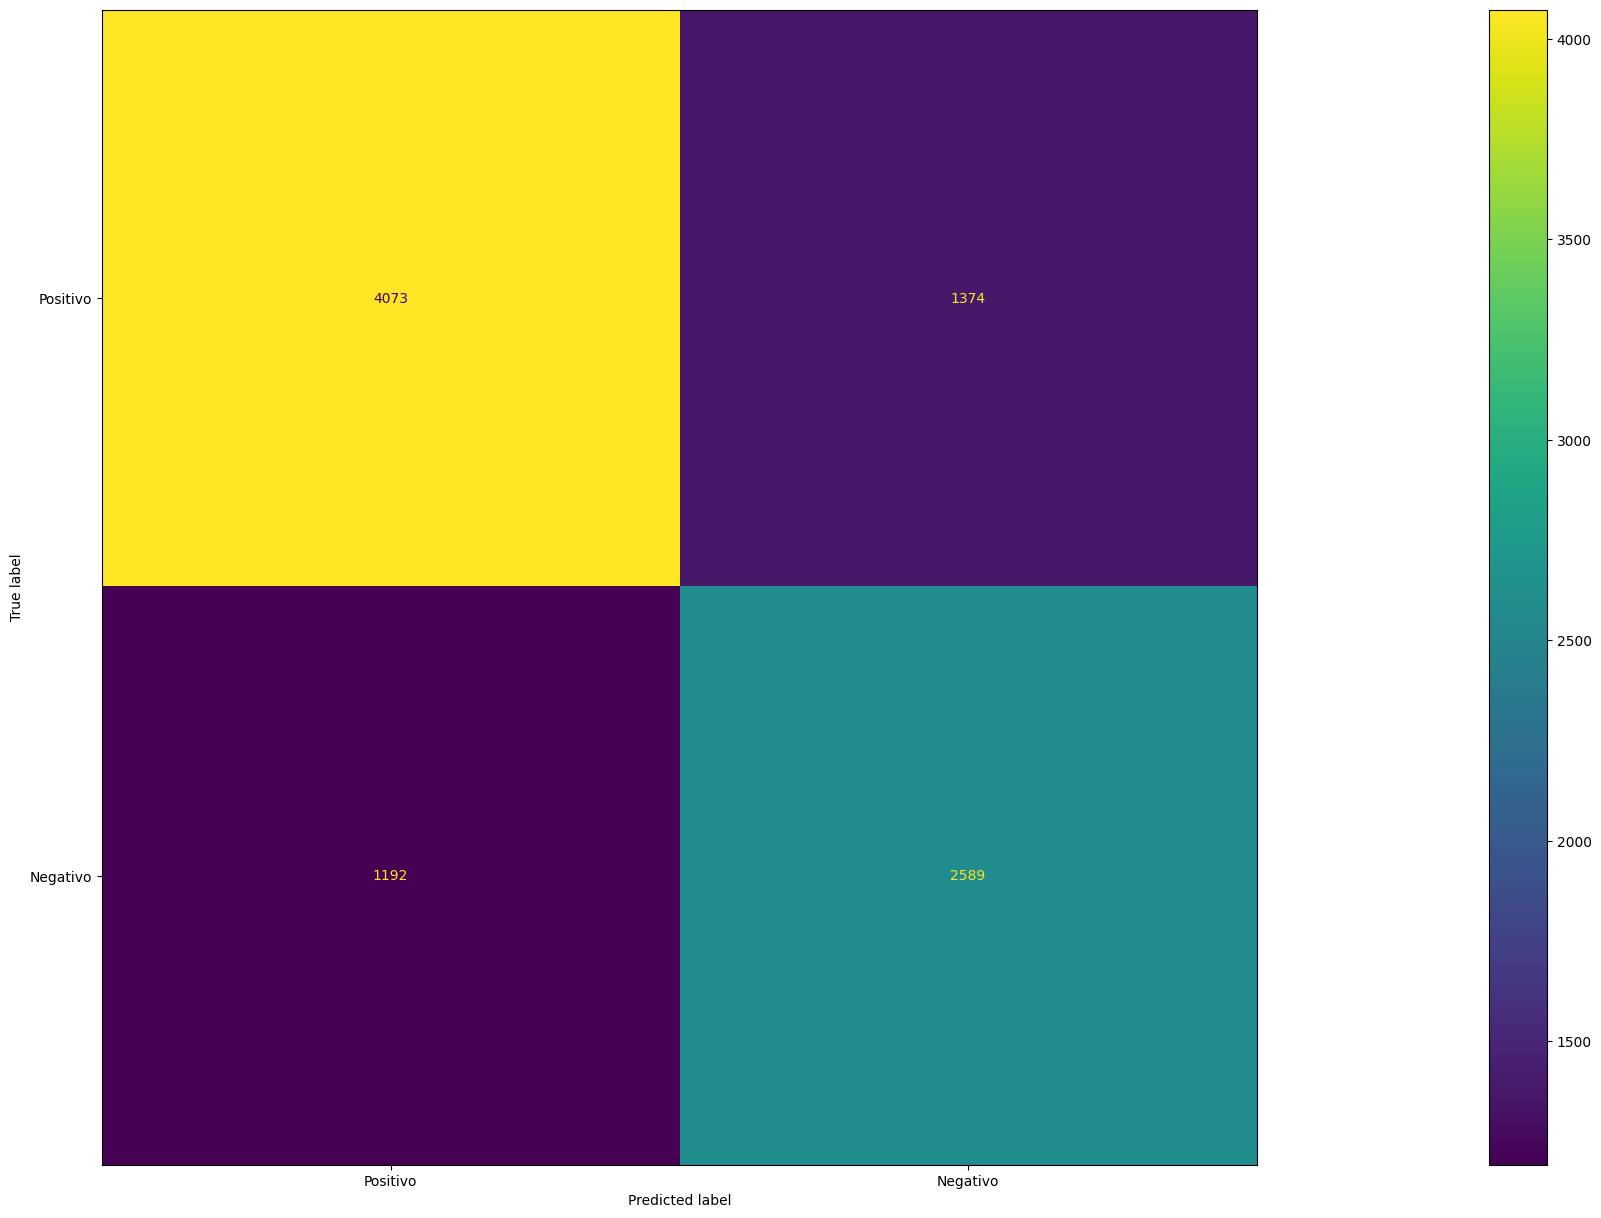

In [70]:
from scipy.spatial.distance import mahalanobis

# Função para classificar uma amostra usando distância de Mahalanobis
def classificar_mahalanobis(amostra, estatisticas_por_classe):
    distancias = {}
    for classe, estatisticas in estatisticas_por_classe.items():
        distancias[classe] = mahalanobis(amostra, estatisticas['media'], np.linalg.inv(estatisticas['covariancia']))
    return min(distancias, key=distancias.get)


test_df['predicao_mahalanobis'] = test_df[['area', 'compacidade', 'excentricidade']].apply(
    lambda x: classificar_mahalanobis(x, estatisticas_treinamento),
    axis=1
)


# Acurácia
acuracia = accuracy_score(test_df['label'], test_df['predicao_mahalanobis'])
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
matriz_confusao = confusion_matrix(test_df['label'], test_df['predicao_mahalanobis'])

y_true = test_df['label']
y_pred = test_df['predicao_mahalanobis']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)


labels = test_df['label'].unique()  # Substitua pelo seu conjunto específico de rótulos
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)


{'Negative for intraepithelial lesion': 0.2835718149186212, 'HSIL': 1.1287923272656097, 'LSIL': 1.4134803921568628, 'ASC-H': 2.0781981981981983, 'ASC-US': 3.172167216721672, 'SCC': 11.939958592132506}
Acurácia: 0.6007802340702211
Matriz de Confusão:
[[  51   27  215   79  375    0]
 [  23   35   66   91  270    0]
 [  71   28  556  124  592    0]
 [  56   49  209  181  598    0]
 [  89   35  386  170 4721    5]
 [   8    3   22   10   83    0]]


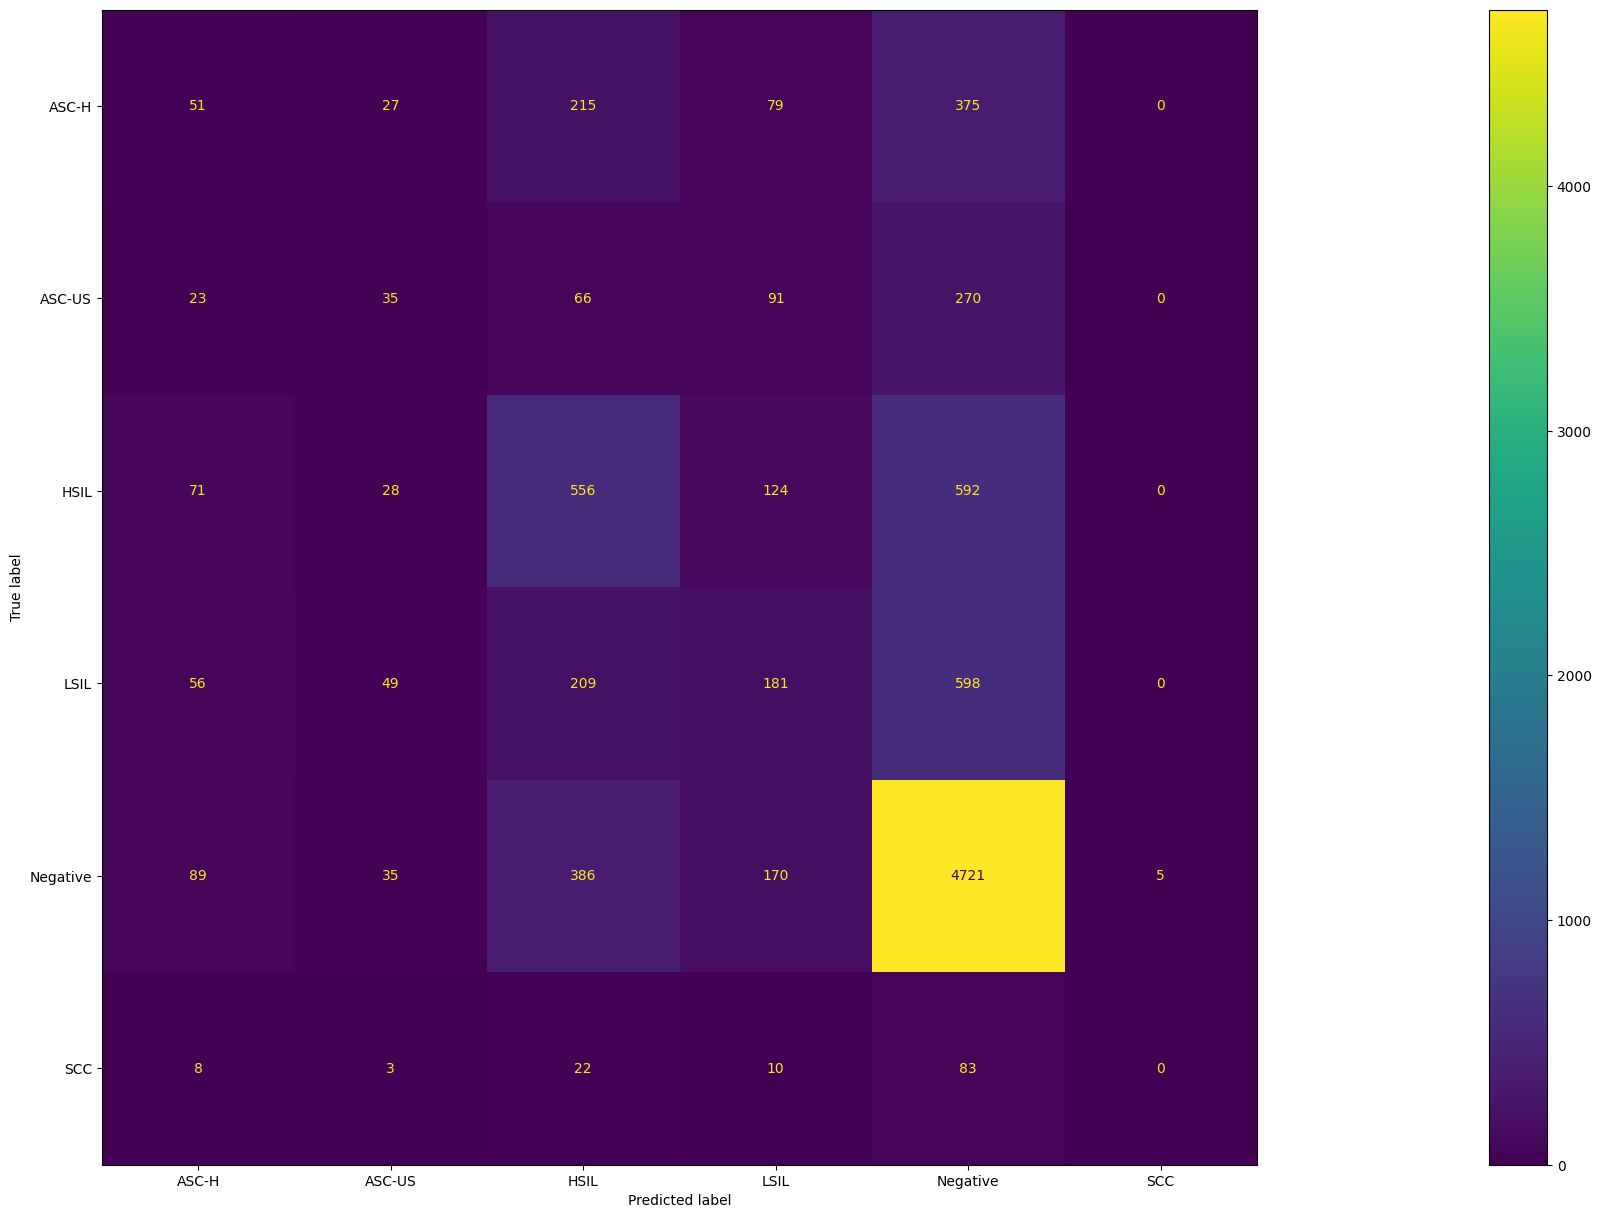

In [45]:
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Função para classificar uma amostra usando distância de Mahalanobis
def classificar_mahalanobis(amostra, estatisticas_por_classe):
    distancias = {}
    for classe, estatisticas in estatisticas_por_classe.items():
        distancias[classe] = mahalanobis(amostra, estatisticas['media'], np.linalg.inv(estatisticas['covariancia']))
    return min(distancias, key=distancias.get)


# test_df['predicao_mahalanobis'] = test_df[['area', 'compacidade', 'excentricidade']].apply(
#     lambda x: classificar_mahalanobis(x, estatisticas_treinamento),
#     axis=1
# )

# knn_classifier = KNeighborsClassifier(n_neighbors=5)
# classificador = RandomForestClassifier(n_estimators=100, random_state=42)

class_counts = df['label'].value_counts()
class_weights = {cls: sum(class_counts) / (len(class_counts) * count) for cls, count in class_counts.items()}

print(class_weights)

# Crie uma instância do RandomForestClassifier com pesos balanceados
clf = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)


y_pred = cross_val_predict(clf, 
                            X=test_df[['area', 'compacidade', 'excentricidade']],  # Conjunto de teste
                            y=test_df['label'], 
                            cv=5)  # Número de folds para a validação cruzada

# Acurácia
acuracia = accuracy_score(test_df['label'], y_pred=y_pred)
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
y_true = test_df['label']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)



labels = ["ASC-H", "ASC-US", "HSIL", "LSIL", "Negative", "SCC"]
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)
